In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e11/sample_submission.csv
/kaggle/input/playground-series-s3e11/train.csv
/kaggle/input/playground-series-s3e11/test.csv


# Importing and first hand look at data

In [2]:
from sklearn.model_selection import train_test_split as tts
train = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")
display(train.head())
test_id = test.id
train = train.set_index('id')
test = test.set_index('id')
y = train.cost
X = train.drop('cost', axis=1)
train_X, val_X, train_y, val_y = tts(X, y, test_size=0.3)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


# Import the modules for plotting

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

# Adding Early Stopping

In [4]:
from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

# Making, compiling and fitting the model using TPUs

Epoch 1/30
1971/1971 [==============================] - 13s 5ms/step - loss: 38.4216 - val_loss: 30.2058
Epoch 2/30
1971/1971 [==============================] - 7s 4ms/step - loss: 30.3945 - val_loss: 29.8445
Epoch 3/30
1971/1971 [==============================] - 9s 4ms/step - loss: 29.3192 - val_loss: 28.5720
Epoch 4/30
1971/1971 [==============================] - 8s 4ms/step - loss: 28.3553 - val_loss: 27.3572
Epoch 5/30
1971/1971 [==============================] - 9s 4ms/step - loss: 27.7507 - val_loss: 29.3397
Epoch 6/30
1971/1971 [==============================] - 7s 4ms/step - loss: 27.0655 - val_loss: 26.4082
Epoch 7/30
1971/1971 [==============================] - 7s 4ms/step - loss: 26.4248 - val_loss: 26.1932
Epoch 8/30
1971/1971 [==============================] - 7s 4ms/step - loss: 26.1199 - val_loss: 26.1447
Epoch 9/30
1971/1971 [==============================] - 9s 4ms/step - loss: 25.9894 - val_loss: 26.0165
Epoch 10/30
1971/1971 [==============================] - 8s 4ms

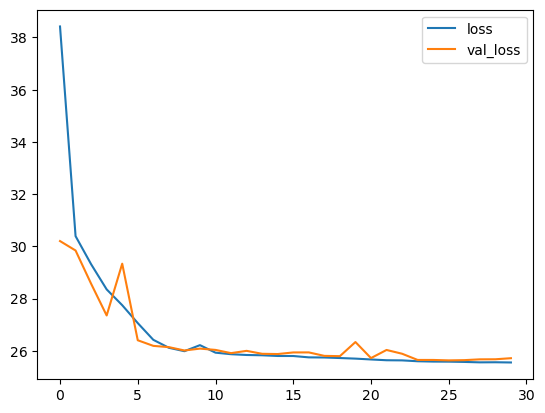

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[15]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae'
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=128,
    epochs=30,
    callbacks=[earlystopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# Predictions

In [6]:
vals = model.predict(test)
vals = pd.DataFrame(vals)
result = pd.merge(test_id, vals, left_index=True, right_index=True)
result.columns=['id', 'cost']
result

7507/7507 [==============================] - 12s 2ms/step


,id,cost
0,360336,112.331558
1,360337,96.199692
2,360338,96.498642
3,360339,102.755814
4,360340,96.797562
...,...,...
240219,600555,96.258621
240220,600556,100.852798
240221,600557,96.477394
240222,600558,102.459633


# Saving to submission csv

In [7]:
result.to_csv("submission.csv",index=False)